In [1]:
# standard python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydataset
import seaborn as sns
from math import sqrt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import statsmodels.api as sm


# my modules
import src.env as env
import src.wrangle as wr
import src.evaluate as evaluate 

# setting random seed to 7
np.random.seed(7)

# turning off red warnings
import warnings
warnings.filterwarnings("ignore")

# module for fixing imported modules
from importlib import reload

In [140]:
df = wr.zillow_2017()

### Some Exploration

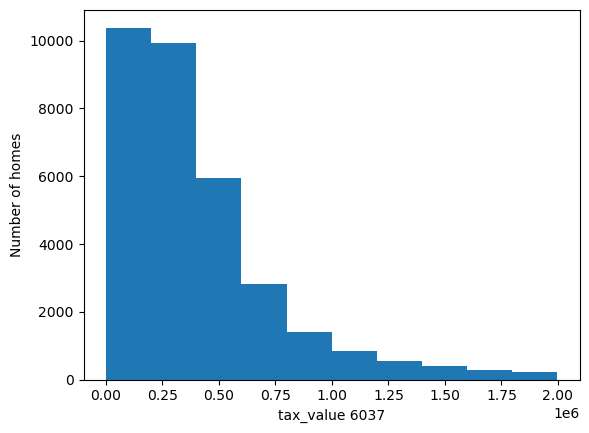

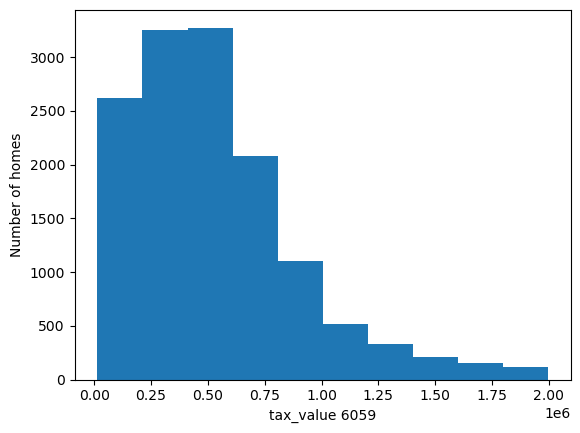

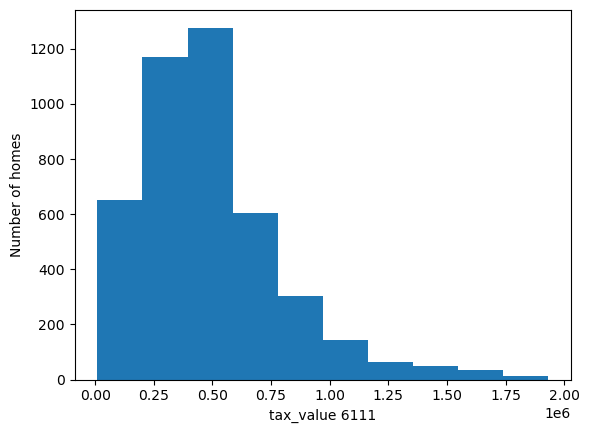

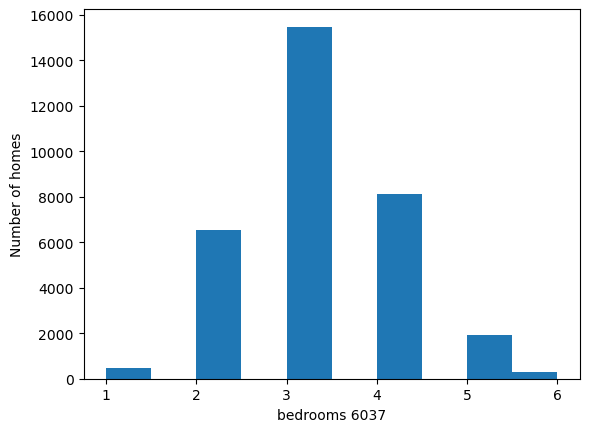

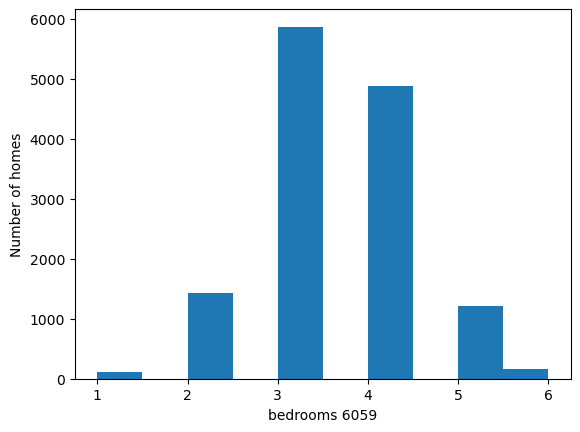

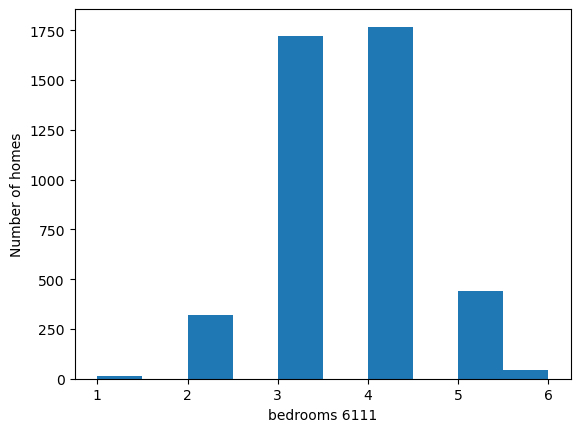

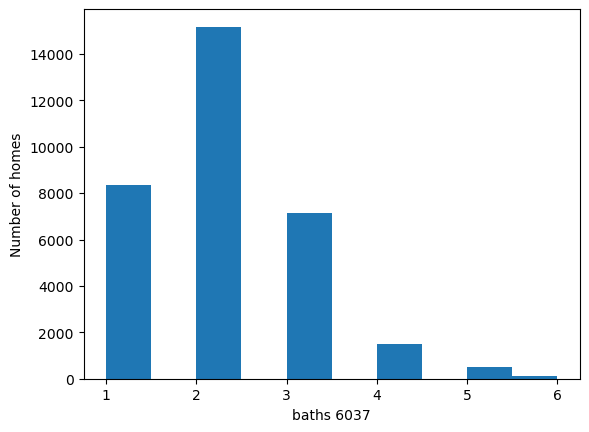

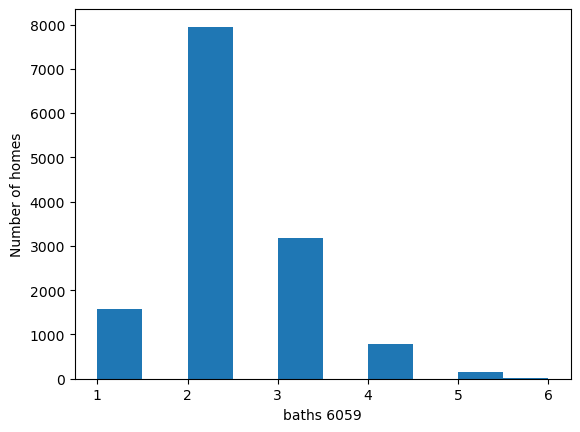

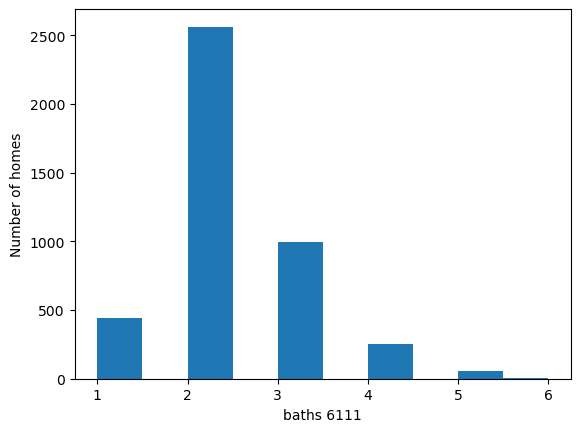

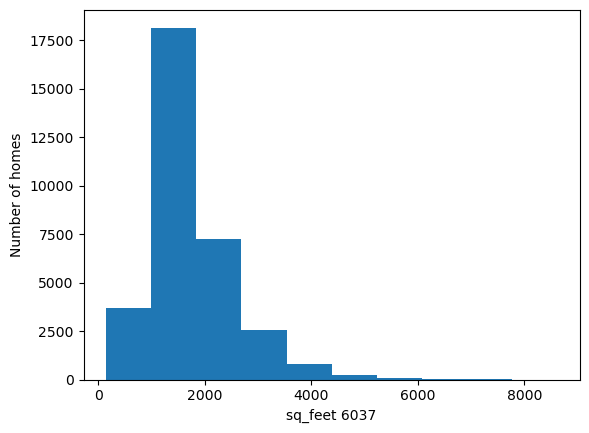

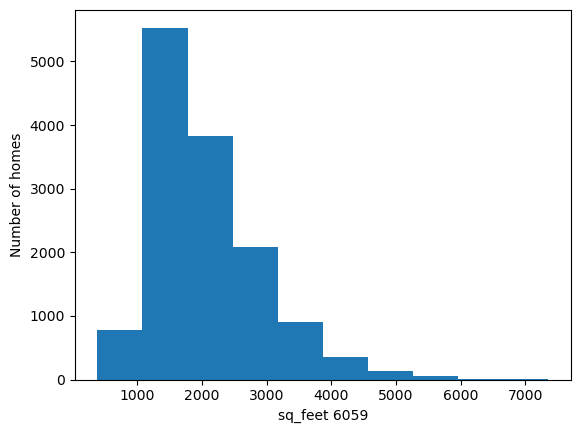

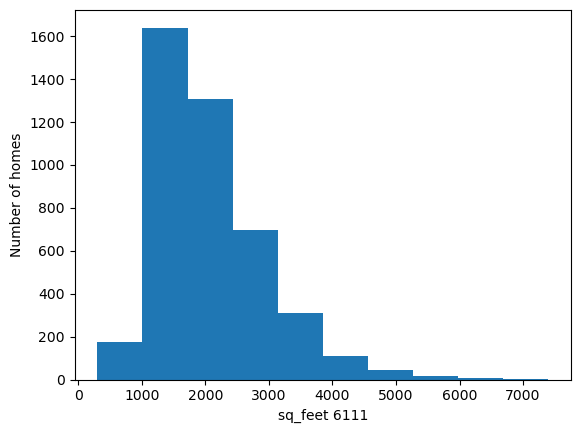

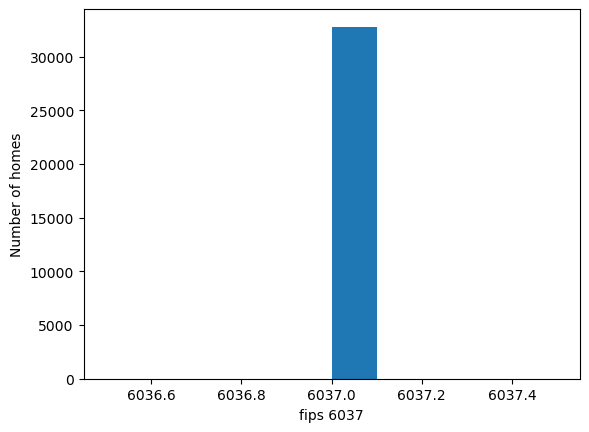

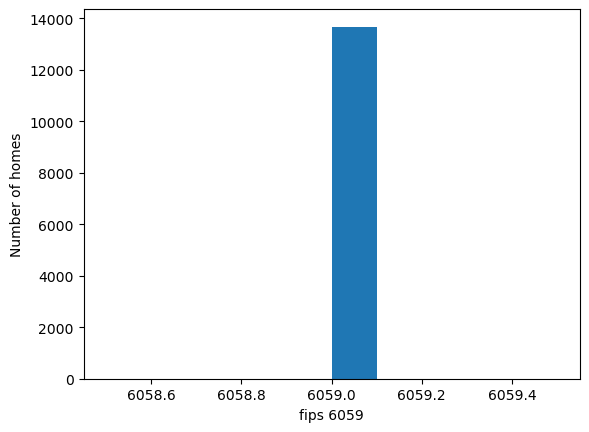

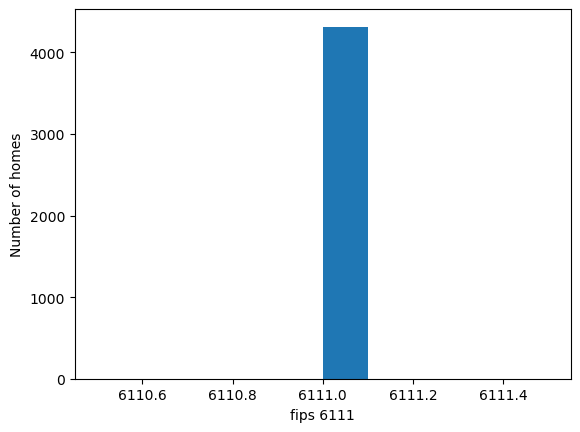

In [3]:
'''
looking at histograms for our county-level, variables: counts per each value in the variable

6037 = Los Angeles County
6059 = Orange County 
6111 = Ventura County
'''
counties = (6037, 6059, 6111)

for i in df.columns:
    for k in counties:
        item = df['fips'] == k
        plt.hist(df[i][item])
        plt.xlabel(f'{i} {k}')
        plt.ylabel('Number of homes')
        plt.show()

In [4]:
#county = df['fips'] == 6037
# 6037 = Los Angeles County
# 6059 = Orange County 
# 6111 = Ventura County

### Separating Data into useful data frames

In [5]:
# forming alternate dataframes using the fips information in order to segment by county
keeper_variables = ['tax_value', 'bedrooms', 'baths', 'sq_feet']

county = df['fips'] == 6037
la_df = df[keeper_variables][county]

county = df['fips'] == 6059
orange_df = df[keeper_variables][county]

county = df['fips'] == 6111
ventura_df = df[keeper_variables][county]

In [6]:
(la_df.shape[0], orange_df.shape[0], ventura_df.shape[0], 
 la_df.shape[0]+ orange_df.shape[0]+ ventura_df.shape[0], df.shape[0])

(32791, 13671, 4314, 50776, 50776)

In [172]:
# separating our data frames into train, validate and test data frames
# further separates our data into our indepdendent and dependent variables

x_train, y_train, x_validate, y_validate, x_test, y_test = wr.x_y(better_df, 'tax_value')

la_x_train, la_y_train, la_x_validate, la_y_validate, la_x_test, la_y_test = wr.x_y(la_df, 'tax_value')

or_x_train, or_y_train, or_x_validate, or_y_validate, or_x_test, or_y_test = wr.x_y(orange_df, 'tax_value')


vent_x_train, vent_y_train, vent_x_validate, vent_y_validate, vent_x_test, vent_y_test = wr.x_y(ventura_df, 'tax_value')

In [173]:
(la_y_test.shape[0],or_y_test.shape[0],vent_y_test.shape[0], 
la_y_test.shape[0]+or_y_test.shape[0]+vent_y_test.shape[0], y_test.shape[0])

(6559, 2735, 863, 10157, 9728)

### Creating results data frame for baseline, simple model and filling it

In [174]:
# creating dataframe to hold values for comparison between prediction models
predictions = pd.DataFrame()

# target column is the variable we are trying to predict with machine learning
predictions['target'] = y_train

# produce baseline predictions based on the mean of the tax values and median values
predictions['baseline_mean'] = round(y_train.mean(),3)
predictions['baseline_median'] = y_train.median()

predictions.head()

,target,baseline_mean,baseline_median
8449,1119396,424408.23,356287.0
46755,497231,424408.23,356287.0
30595,669514,424408.23,356287.0
35736,116712,424408.23,356287.0
2674,138299,424408.23,356287.0


In [175]:
# creating simple regression model BEFORE splitting by county

# make the model
lm = LinearRegression()

# fit data to simple regression
lm.fit(x_train, y_train)

# make predictions
predictions['simple_model2'] = lm.predict(x_train)

In [18]:
# reordering columns in predictions dataframe
#predictions = predictions.iloc[:,[1,2,3]]

In [176]:
predictions.columns

Index(['target', 'baseline_mean', 'baseline_median', 'simple_model2'], dtype='object')

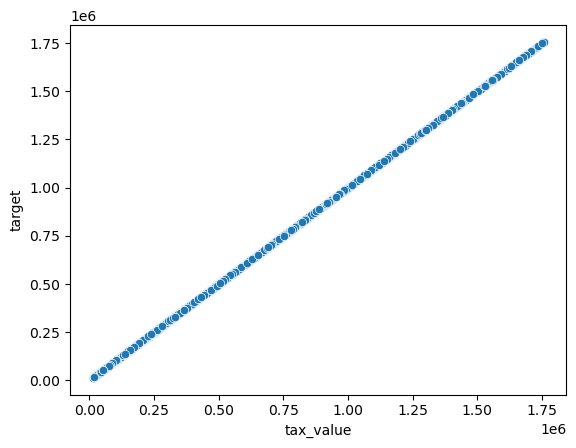

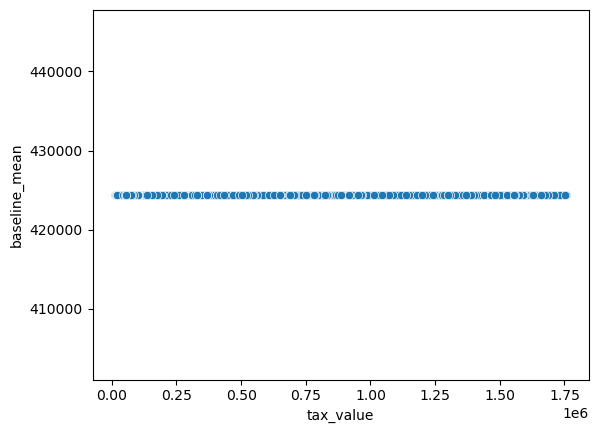

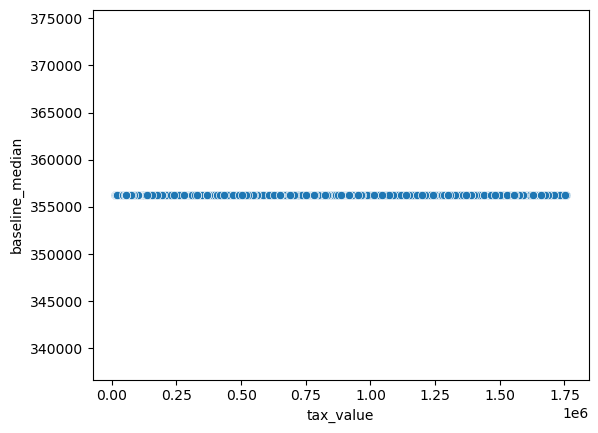

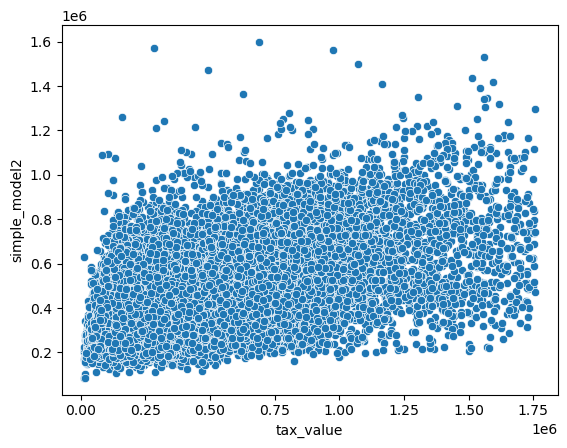

In [177]:
for i in predictions.columns:
    evaluate.plot_residuals(y_train,predictions[i])
    plt.show()

In [57]:
def measure_performance(df):
    test_test = pd.DataFrame()
    for i in df.columns:
        test_test = test_test.append(evaluate.regression_errors(df['target'], df[i], df=True, features=4), ignore_index=True)
        #test_test['Model'] = predictions.columns[i]
        #test_test.set_index(predictions.columns[i], inplace=True)


    test_test['Model'] = np.array(df.columns)
    test_test.set_index('Model', inplace=True)
    return test_test



In [167]:
better_df.rename(columns = {'tax_value':'target'}, inplace=True) 

In [162]:
a

,ESS,SSE,TSS,MSE,RMSE,R^2,AdjR^2
Model,,,,,,,
target,3.571283e+15,0.000000e+00,3.571283e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,4.000000e-03,3.571283e+15,3.571283e+15,1.255990e+11,354399.535,-0.000,-0.000
baseline_median,1.889140e+14,3.760197e+15,3.949111e+15,1.322430e+11,363652.278,-0.053,-0.053
simple_model,1.242862e+15,2.328421e+15,3.571283e+15,8.188862e+10,286161.880,0.348,0.348


In [179]:
b = measure_performance(predictions)
b

,ESS,SSE,TSS,MSE,RMSE,R^2,AdjR^2
Model,,,,,,,
target,2.795146e+15,0.000000e+00,2.795146e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,3.000000e-03,2.795146e+15,2.795146e+15,1.026269e+11,320354.303,0.000,-0.000
baseline_median,1.263887e+14,2.921534e+15,3.047923e+15,1.072674e+11,327516.994,-0.045,-0.045
simple_model2,8.390040e+14,1.956142e+15,2.795146e+15,7.182191e+10,267996.108,0.300,0.300


### Those models performed pretty poorly. Baseline is terrible, regardless of it being the mean version or median version. The simple model worked better but was similarly awful. 

- time to work on tossing more outliers

In [60]:
df.columns

Index(['tax_value', 'bedrooms', 'baths', 'sq_feet', 'fips'], dtype='object')

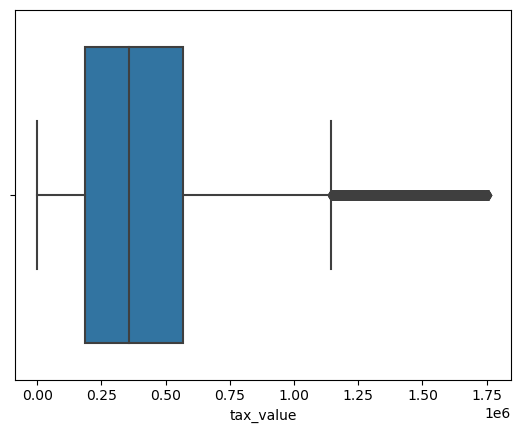

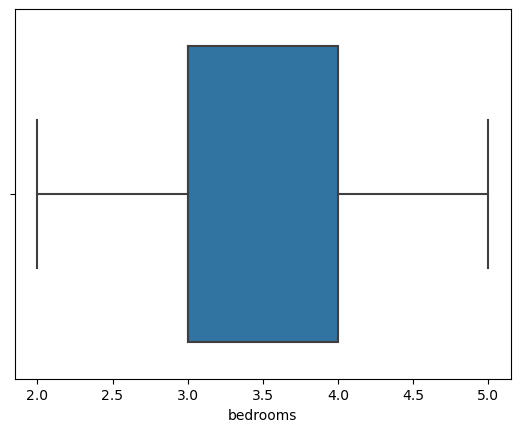

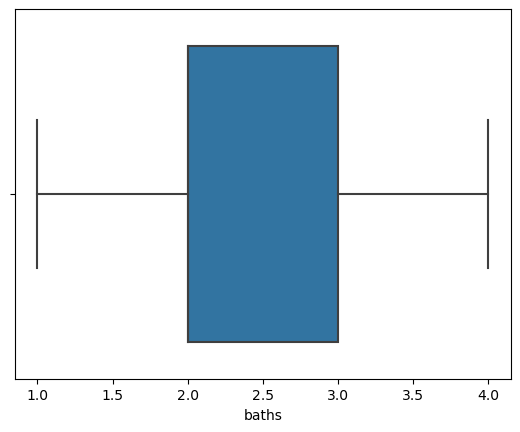

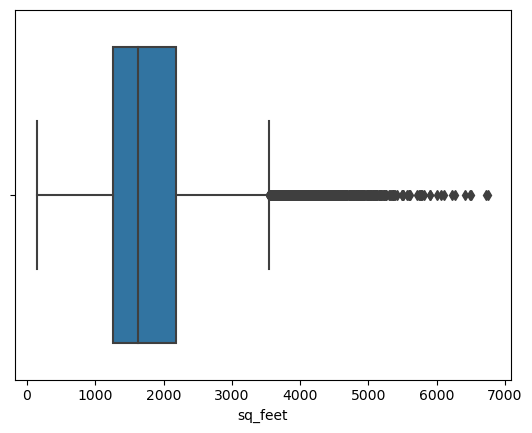

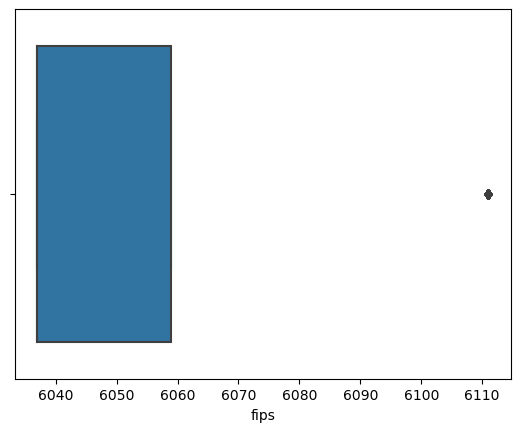

In [154]:
for i in df.columns:
    sns.boxplot(x = better_df[i])
    plt.show()

In [123]:
(df['tax_value'].max())*.88

1757580.8800000001

In [127]:
df[bool2].count()/(df.count())*100

tax_value    0.83701
bedrooms     0.83701
baths        0.83701
sq_feet      0.83701
fips         0.83701
dtype: float64

In [148]:
df[df.baths <= 4].count()

tax_value    49904
bedrooms     49904
baths        49904
sq_feet      49904
fips         49904
dtype: int64

In [149]:
bathroom_bool = df['baths'] <= 4
df[bool2].count()

tax_value    49904
bedrooms     49904
baths        49904
sq_feet      49904
fips         49904
dtype: int64

In [150]:
high_bed_bool = df['bedrooms'] <= 5 
low_bed_bool  = df['bedrooms'] > 1
tax_bool = df['tax_value'] < 1757580
bathroom_bool = df['baths'] <= 4

In [170]:
# county = df['fips'] == 6037
better_df = df
better_df = better_df[high_bed_bool & low_bed_bool]
better_df = better_df[tax_bool]
better_df = better_df[bathroom_bool]

In [171]:
better_df

,tax_value,bedrooms,baths,sq_feet,fips
0,1023282,4,3,3100,6059
1,464000,2,1,1465,6111
2,564778,3,2,1243,6059
3,145143,4,3,2376,6037
4,773303,4,3,2962,6037
...,...,...,...,...,...
52284,354621,2,2,1286,6037
52285,67205,4,2,1612,6111
52286,49546,3,1,1032,6037
52287,522000,3,2,1762,6037


<AxesSubplot:xlabel='bedrooms'>

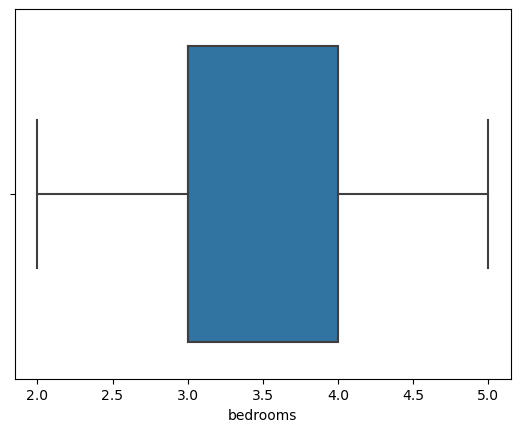

In [105]:
sns.boxplot(x = better_df['bedrooms'])

In [181]:
a.concat(b)

AttributeError: 'DataFrame' object has no attribute 'concat'

In [184]:
comparison_df = pd.concat([a, b], axis=0)

In [185]:
comparison_df

,ESS,SSE,TSS,MSE,RMSE,R^2,AdjR^2
Model,,,,,,,
target,3.571283e+15,0.000000e+00,3.571283e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,4.000000e-03,3.571283e+15,3.571283e+15,1.255990e+11,354399.535,-0.000,-0.000
baseline_median,1.889140e+14,3.760197e+15,3.949111e+15,1.322430e+11,363652.278,-0.053,-0.053
simple_model,1.242862e+15,2.328421e+15,3.571283e+15,8.188862e+10,286161.880,0.348,0.348
target,2.795146e+15,0.000000e+00,2.795146e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,3.000000e-03,2.795146e+15,2.795146e+15,1.026269e+11,320354.303,0.000,-0.000
baseline_median,1.263887e+14,2.921534e+15,3.047923e+15,1.072674e+11,327516.994,-0.045,-0.045
simple_model2,8.390040e+14,1.956142e+15,2.795146e+15,7.182191e+10,267996.108,0.300,0.300
